In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f'Value(data={self.data}, label={self.label})'

    # addition
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        # back propogation specifically for the addition
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    # multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        # back propogation specifically for multiplication
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    # temporary activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    # backpropogation to be performed given neuron connections
    def backward(self):
        # first need to topologicall sort connected neurons
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        # build the topological sort to prepare for backpropogation
        build_topo(self)

        # now we want the back propogation to happen after the sort
        self.grad = 1.0 # since gradient of last neuron will be 1
        for node in reversed(topo):
            # will call whatever backprop method is needed from other methods
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0, label=L)

In [11]:
print(f'previous: {d._prev};\noperation: {d._op}')

previous: {Value(data=10.0, label=c), Value(data=-6.0, label=e)};
operation: +


We want to know how to find the gradients of L with respect to all other Values
- for instance, what is dL / dc ?
We can use the chain rule to figure this out, since we don't know this directly
dL / dc = dL / dd * dd / dc = -2 * 1 = -2

and then same thing will apply to e:
dL / de = dL / dd * dd / de = -2

what about dL / da ? 

dL / da = dL / de * de / da 

well we know that e = a * b

so that means de / da = b

therefore dL / da = -2 * (-3) = 6
and dL / db = dL / de * de / db = -2 * (a) = -2 * 2 = -4

In [12]:
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [13]:
from graphviz import Digraph

def trace(root):
    # construct graph with nodes and connected edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for every value in the graph, create a node for it
        dot.node(name = uid, label='{%s | data = %.2f | grad %.2f}' % (n.label, n.data, n.grad), shape='record')
        
        # if the current node is an operation, create a node for it
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [14]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

a.data += 0.01 * a.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d*f

print(L)

Value(data=-7.448000000000001, label=)


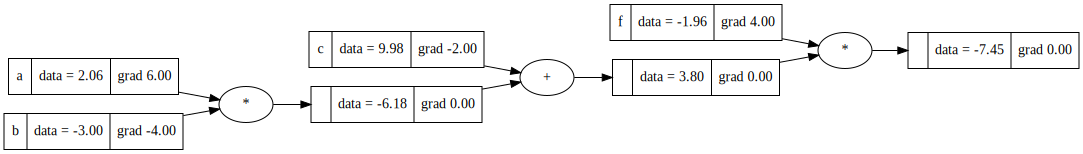

In [15]:
draw_dot(L)

In [16]:
o.backward()

NameError: name 'o' is not defined

In [17]:
def lol():
    h = 1e-3
    print(f'h: {h}')
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    print(L1)
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    d.data
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    print(L2)
    
    print(L2-L1)
    print((L2-L1)/h)

In [18]:
lol()

h: 0.001
-8.0
-7.994
0.006000000000000227
6.000000000000227


Now let's start making neurons and applying activation functions to them

In [19]:
# instantiate inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# instantiate weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# now add things together 
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [20]:
o.backward()

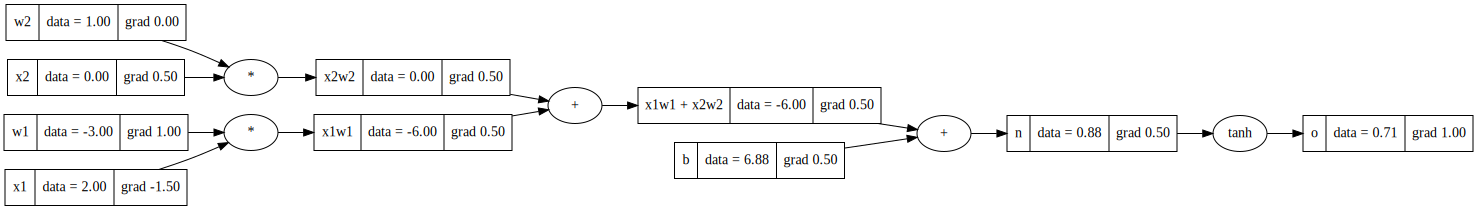

In [21]:
draw_dot(o)

In [13]:
o.grad = 1.0

In [14]:
o._backward()

In [15]:
n._backward()

In [16]:
x1w1x2w2._backward()

In [17]:
x1w1._backward()

In [18]:
x2w2._backward()

In [19]:
o.grad = 1.0

Now let's figure out how to get the gradient of n
since o = tanh(n)
then do/dn = 1 - o**2 since d(tanh(x))/dx = 1 - (tanh(x))**2
so this means n.grad = 1 - o**2 = 0.5

In [20]:
n.grad = 0.5

Okay how do I get the next set of derivatives, i.e. do / db and do / x1w1 + x2w2 ? 
chain rule you guys! chen lu!
do / db = do / dn * dn / db = (0.5) * d(x1w1 + x2w2 + b)/db = (0.5) * 1 = 0.5
do / d(x1w1 + x2w2) = do / dn * dn / d(x1w1 + x2w2 + b) = 0.5 * 1 = 0.5

In [21]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

Now we need to get the other ones!
do / d(x1w1) = do / d(x1w1 + x2w2) * d(x1w1 + x2w2) / d(x1w1) = 0.5 * 1 = 0.5
do / d(x2w2) = do / d(x1w1 + x2w2) * d(x1w1 + x2w2) / d(x2w2) = 0.5 * 1 = 0.5

so basically the addition carries a 1 with all of it's chained derivatives!

In [22]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [23]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [24]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
            
        topo.append(v)
    
# start topological sort at the last point, o
build_topo(o)
topo

[Value(data=2.0, label=x1),
 Value(data=-3.0, label=w1),
 Value(data=-6.0, label=x1w1),
 Value(data=1.0, label=w2),
 Value(data=0.0, label=x2),
 Value(data=0.0, label=x2w2),
 Value(data=-6.0, label=x1w1 + x2w2),
 Value(data=6.881373587019543, label=b),
 Value(data=0.8813735870195432, label=n),
 Value(data=0.7071067811865476, label=o)]

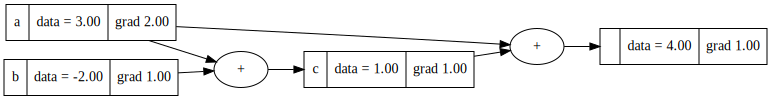

In [42]:
a = Value(3.0, label='a')
b = Value(-2.0, label='b')
c = a + b; c.label='c'
d = a + c; label='d'
d.backward()
draw_dot(d)